In [15]:
# Install required packages
!pip install xgboost scikit-learn matplotlib seaborn


In [17]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [18]:
# Unzip the dataset
zip_path = "/content/archive (11).zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/data")

# Find CSV file in extracted folder
for root, dirs, files in os.walk("/content/data"):
    for file in files:
        if file.endswith(".csv"):
            csv_path = os.path.join(root, file)
            print(f"CSV File Found: {csv_path}")

# Load the CSV into a DataFrame
df = pd.read_csv(csv_path)
df.head()


CSV File Found: /content/data/diabetes_dataset_with_notes.csv


,year,gender,age,location,race:AfricanAmerican,race:Asian,race:Caucasian,race:Hispanic,race:Other,hypertension,heart_disease,smoking_history,bmi,hbA1c_level,blood_glucose_level,diabetes,clinical_notes
0,2020,Female,32.0,Alabama,0,0,0,0,1,0,0,never,27.32,5.0,100,0,"Overweight, advised dietary and exercise modif..."
1,2015,Female,29.0,Alabama,0,1,0,0,0,0,0,never,19.95,5.0,90,0,Healthy BMI range.
2,2015,Male,18.0,Alabama,0,0,0,0,1,0,0,never,23.76,4.8,160,0,"Young patient, generally lower risk but needs ..."
3,2015,Male,41.0,Alabama,0,0,1,0,0,0,0,never,27.32,4.0,159,0,"Overweight, advised dietary and exercise modif..."
4,2016,Female,52.0,Alabama,1,0,0,0,0,0,0,never,23.75,6.5,90,0,"Healthy BMI range. High HbA1c level, indicativ..."


In [19]:
# Drop unnecessary columns
df.drop(columns=['clinical_notes', 'location'], inplace=True)

# Encode categorical variables
label_encoders = {}
for col in ['gender', 'smoking_history']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Define features and label
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [20]:
# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Chi-Square (requires non-negative)
X_train_chi2 = X_train - X_train.min()
X_test_chi2 = X_test - X_train.min()
chi2_selector = SelectKBest(score_func=chi2, k=10)
X_train_chi2 = chi2_selector.fit_transform(X_train_chi2, y_train)
X_test_chi2 = chi2_selector.transform(X_test_chi2)


In [21]:
models = {
    "Logistic Regression": (LogisticRegression(), {'C': [0.1, 1, 10]}),
    "Random Forest": (RandomForestClassifier(), {'n_estimators': [100, 200], 'max_depth': [5, 10]}),
    "SVM": (SVC(probability=True), {'C': [1, 10], 'kernel': ['linear', 'rbf']}),
    "KNN": (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7]}),
    "XGBoost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {'n_estimators': [100, 200]})
}

results = {}


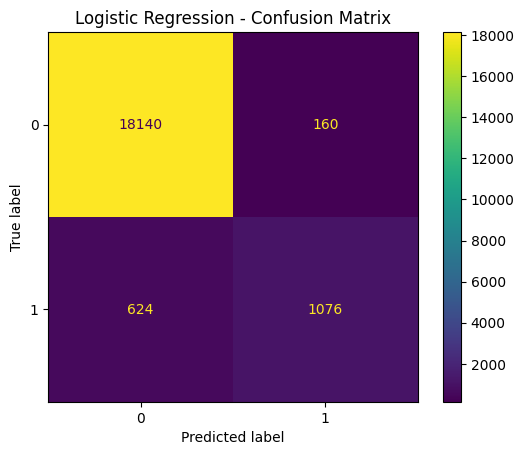

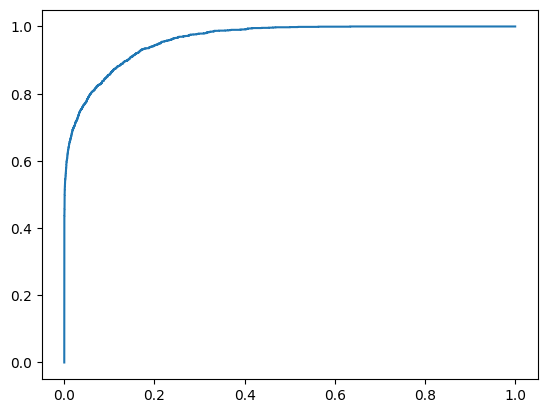

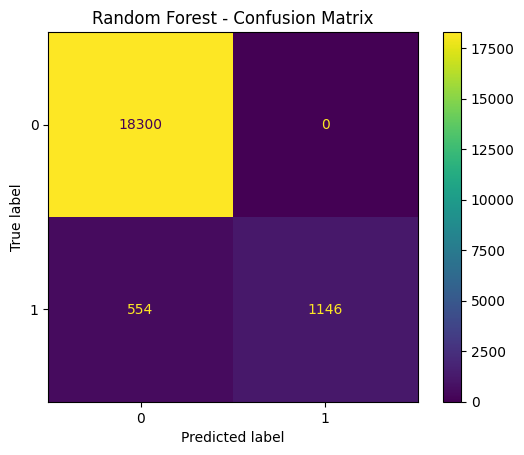

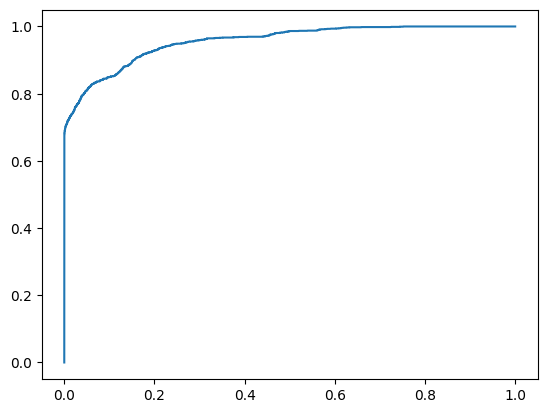

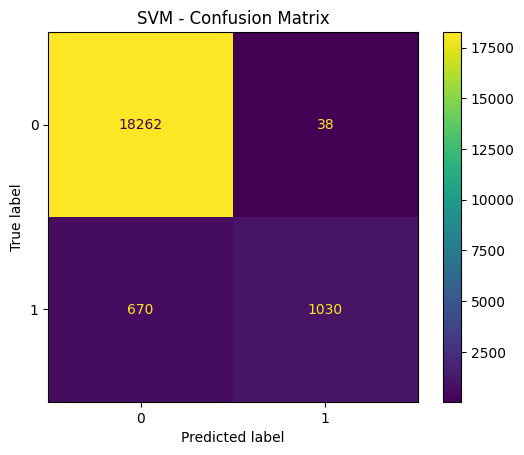

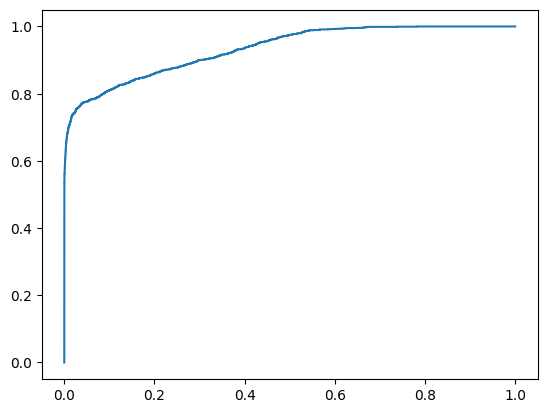

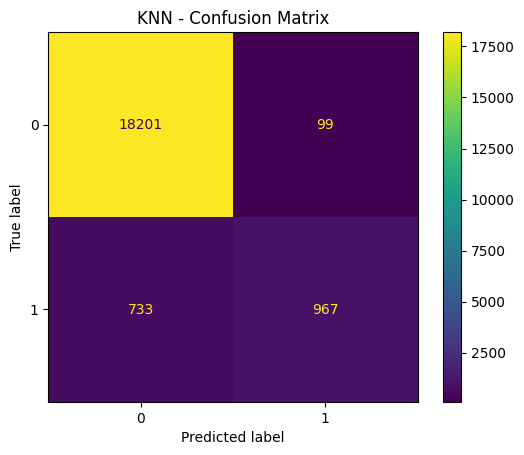

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:27:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


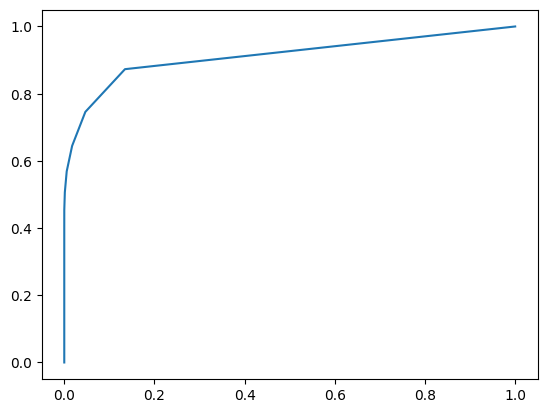

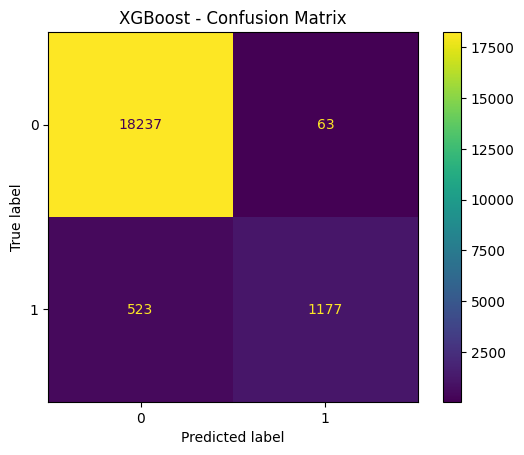

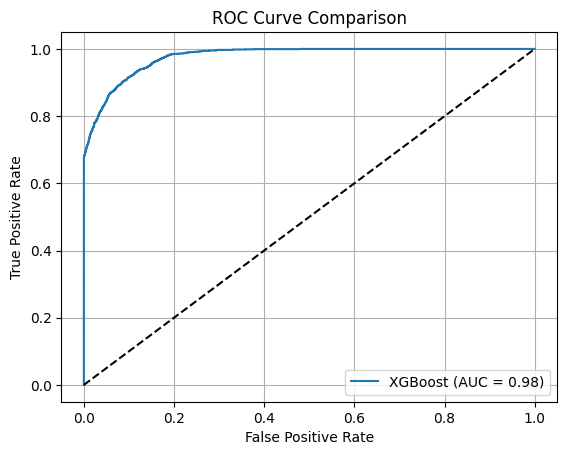

In [23]:
for name, (model, params) in models.items():
    clf = GridSearchCV(model, params, cv=2, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Store results
    results[name] = {
        "model": clf.best_estimator_,
        "accuracy": clf.score(X_test, y_test),
        "confusion_matrix": confusion_matrix(y_test, y_pred),
        "roc_auc": auc(*roc_curve(y_test, y_prob)[:2])
    }

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=results[name]["confusion_matrix"])
    disp.plot()
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["roc_auc"]:.2f})')

# Final ROC plot
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [24]:
# Accuracy and AUC
print("Model Performance Summary:")
for name, res in results.items():
    print(f"{name}: Accuracy = {res['accuracy']:.4f}, AUC = {res['roc_auc']:.4f}")


Model Performance Summary:
Logistic Regression: Accuracy = 0.9608, AUC = 0.9613
Random Forest: Accuracy = 0.9723, AUC = 0.9561
SVM: Accuracy = 0.9646, AUC = 0.9332
KNN: Accuracy = 0.9584, AUC = 0.9120
XGBoost: Accuracy = 0.9707, AUC = 0.9773
